## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pylops
import time

## Load image and computes values of A and b 

In [2]:
def load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator.png"):
    sampling_x = 2
    sampling_y = 2
    im = np.load(file_name)[::sampling_x, ::sampling_y, 2]
    Nz, Nx = im.shape

    # Blurring Gaussian operator
    nh = [15, 25]
    hz = np.exp(-0.1 * np.linspace(-(nh[0] // 2), nh[0] // 2, nh[0]) ** 2)
    hx = np.exp(-0.3 * np.linspace(-(nh[1] // 2), nh[1] // 2, nh[1]) ** 2)
    hz /= np.trapz(hz)  # normalize the integral to 1
    hx /= np.trapz(hx)  # normalize the integral to 1
    h = hz[:, np.newaxis] * hx[np.newaxis, :]

    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    him = ax.imshow(h)
    ax.set_title("Blurring operator")
    fig.colorbar(him, ax=ax)
    ax.axis("tight")
    plt.savefig(filename_courbe)
    plt.show()
    Cop = pylops.signalprocessing.Convolve2D(
        (Nz, Nx), h=h, offset=(nh[0] // 2, nh[1] // 2), dtype="float32"
    )

    imblur = Cop * im
    plt.imshow(im, cmap="viridis", vmin=0, vmax=255)
    plt.show()
    plt.imshow(imblur, cmap="viridis", vmin=0, vmax=255)
    plt.show()
   

    Wop = pylops.signalprocessing.DWT2D((Nz, Nx), wavelet="haar", level=3)

    # This is your A and b for your f1 cost!
    A = Cop * Wop.H
    b = imblur.ravel()

    return Wop, A, b, im, imblur

## Code of ISTA and FISTA algorithms

In [3]:
def my_fista(A, b, opt_cost, eps=1e-1, niter=200, tol=1e-10, acceleration=False, alp = None ):
    
    if alp is None:
        alp = 1/(2*((A.T @ A).eigs(neigs=1, symmetric=True)))
        
    x = np.ones(A.shape[1])  # Corrigido para se ajustar ao tamanho correto de A
    opt_gap_cost = [0.5 * (np.linalg.norm(A @ x - b, 2))**2 + eps * np.linalg.norm(x, 1)]
        
    if acceleration==False : 
       
        for i in range(niter):
    
            # Gradiente do problema quadrático
            grad = A.T @ (A @ x - b)
    
            # Aplicação da atualização com escolha condicional
            conditions = [x - 2 * alp * grad > alp * eps, x - 2 * alp * grad < -alp * eps]
            choices = [x - 2 * alp * grad - alp * eps, x - 2 * alp * grad + alp * eps]
    
            x = np.select(conditions, choices, default=0)
    
            # Cálculo do custo atualizado
            cost = 0.5 * (np.linalg.norm(A @ x - b, 2))**2 + eps * np.linalg.norm(x, 1)
            opt_gap_cost.append(cost-opt_cost)
    
            # Convergência
            if abs(opt_gap_cost[-1] - opt_gap_cost[-2]) < tol:
                break
                
    if acceleration==True : 
        lam0 = 0
        lamnew = 0
        y = x.copy()
        yint = x.copy()
        for i in range(niter):
            
                 # Gradiente do problema quadrático
                 grad = A.T @ (A @ x - b)
                
                 lamnew = (1 + np.sqrt(1+4*(lam0**2)))/2 
                 gama = (1-lam0)/lamnew

                 
                 # Aplicação da atualização com escolha condicional
                 conditions = [x - 2 * alp * grad > alp * eps, x - 2 * alp * grad < -alp * eps]
                 choices = [x - 2 * alp * grad - alp * eps, x - 2 * alp * grad + alp * eps]
    
    
                 yint = np.select(conditions, choices, default=0)
                 x = gama*y + (1-gama)*yint
            
                 # Cálculo do custo atualizado
                 cost = 0.5 * (np.linalg.norm(A @ x - b, 2))**2 + eps * np.linalg.norm(x, 1)
                 opt_gap_cost.append(cost-opt_cost)
    
                 
                 lam0 =lamnew
                 y = yint
            
                 # Convergência
                 if abs(opt_gap_cost[-1] - opt_gap_cost[-2]) < tol:
                     break

    
    return x, opt_gap_cost

## Main program

In [4]:
def run_program(A, b, Wop, eps_value=0.1, baseline_iter=1000, my_iter=100, filename_courbe="Courbe.png", alp = None):

    start_time_total = time.time()
    
    # Baseline from pylops
    imdeblurfista0, n_eff_iter, cost_history = pylops.optimization.sparsity.fista(
        A, b, eps=eps_value, niter=baseline_iter
    )
    
    if alp is None:
        alp = 1/(2*((A.T @ A).eigs(neigs=1, symmetric=True)))

    opt_cost = cost_history[-1]

    # ISTA
    start_time_ista = time.time()
    my_imdeblurfista, opt_gap_cost = my_fista(
        A, b, opt_cost, eps=eps_value, niter=my_iter, acceleration=False, alp = alp)
    ista_time = time.time() - start_time_ista
    print(f"Temps d'exécution pour ISTA: {ista_time:.2f} secondes")

    # FISTA
    start_time_FISTA = time.time()
    my_imdeblurfista1, opt_gap_cost1 = my_fista(
        A, b, opt_cost, eps=eps_value, niter=my_iter, acceleration=True, alp = alp)
    FISTA_time = time.time() - start_time_FISTA
    print(f"Temps d'exécution pour FISTA: {FISTA_time:.2f} secondes")

     # Temps total
    total_time = time.time() - start_time_total
    print(f"Temps d'exécution total: {total_time:.2f} secondes")

    
    plt.loglog(opt_gap_cost, 'C0', label='ISTA')
    plt.loglog(opt_gap_cost1, 'C1', label='FISTA')
    plt.grid()
    plt.loglog([3, 30], [1e6, 1e5], 'C0--', label='1/k')
    plt.loglog([3, 30], [.5e5, .5e3], 'C1--', label='1/k2')

    plt.legend()
    plt.savefig(filename_courbe)
    plt.show()
    

    imdeblurfista = my_imdeblurfista1.reshape(A.dims)
    imdeblurfista = Wop.H * imdeblurfista

    # Ajouter des informations sur les dimensions du problème
    print(f"Dimensions du problème: A shape = {A.shape}")

    return imdeblurfista


## Function to visualize plots

In [5]:
def visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred.png"):
    #Change viridis into gray for castle image.

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95, x=0.32)
    ax1 = plt.subplot2grid((2, 5), (0, 0))
    ax2 = plt.subplot2grid((2, 5), (0, 1))
    ax3 = plt.subplot2grid((2, 5), (0, 2))

    ax1.imshow(im, cmap="viridis", vmin=0, vmax=250)
    ax1.axis("tight")
    ax1.set_title("Original")
    ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
    ax2.axis("tight")
    ax2.set_title("Blurred")

    ax3.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
    ax3.axis("tight")
    ax3.set_title("FISTA deblurred")

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

    plt.savefig(filename_dog, bbox_inches='tight')
    plt.show()
   

## Test of algorithms : objective convergence & resulting images with $\alpha$ = $1/L$

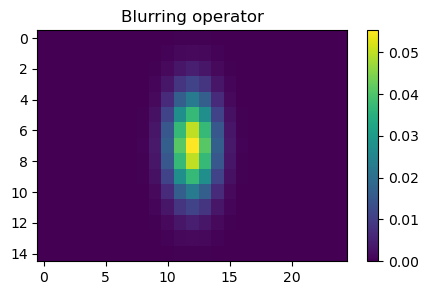

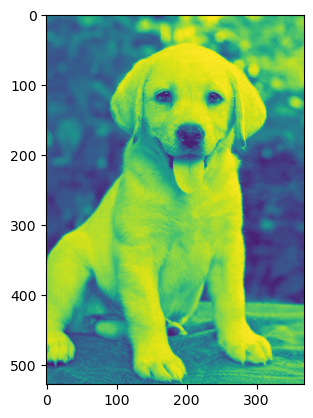

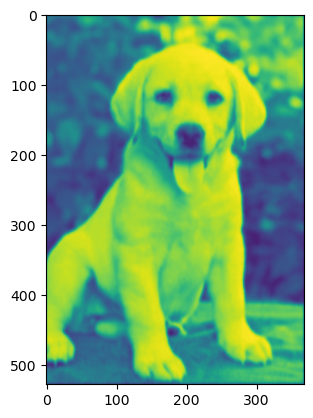

Temps d'exécution pour ISTA: 8.54 secondes
Temps d'exécution pour FISTA: 8.67 secondes
Temps d'exécution total: 297.66 secondes


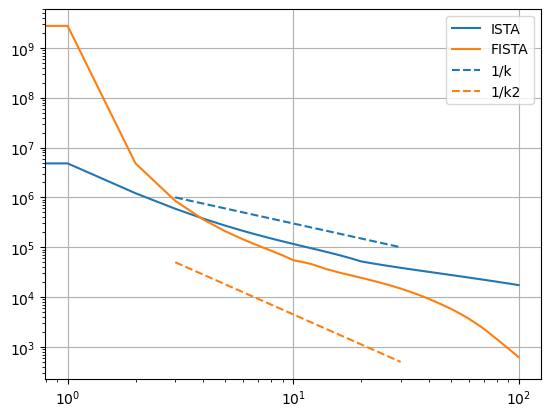

Dimensions du problème: A shape = (194304, 524288)


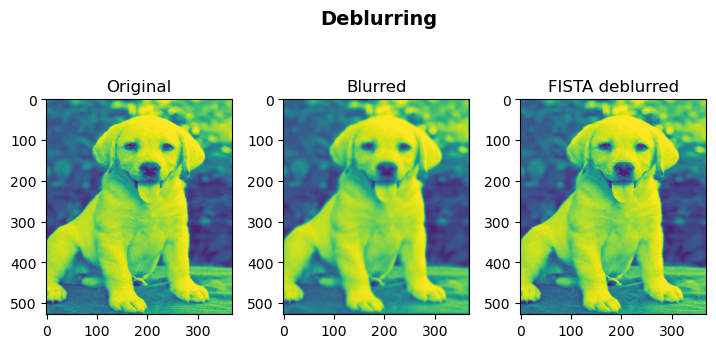

In [6]:
Wop, A, b, im, imblur = load_image_option_I()
 
imdeblurfista = run_program(A,b, Wop)

visualise_results(im, imblur, imdeblurfista)

## Testing with different values of $\epsilon$ 

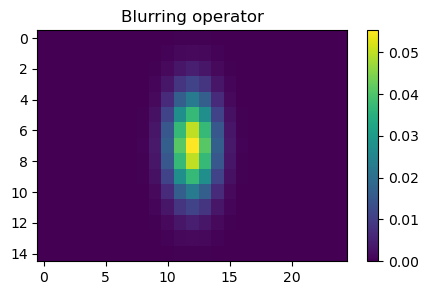

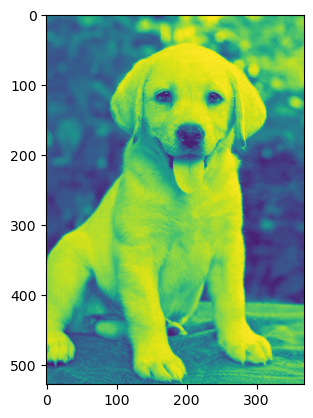

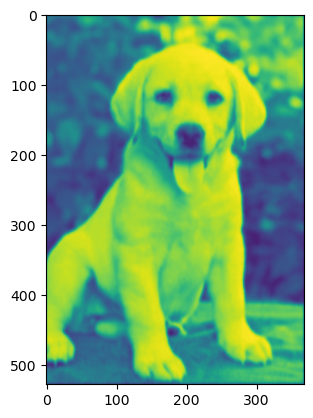

Temps d'exécution pour ISTA: 7.62 secondes
Temps d'exécution pour FISTA: 8.79 secondes
Temps d'exécution total: 256.95 secondes


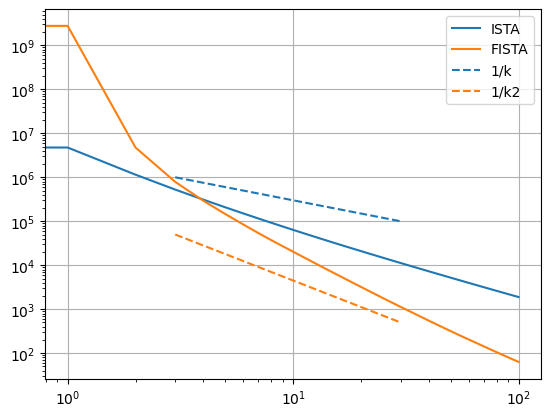

Dimensions du problème: A shape = (194304, 524288)


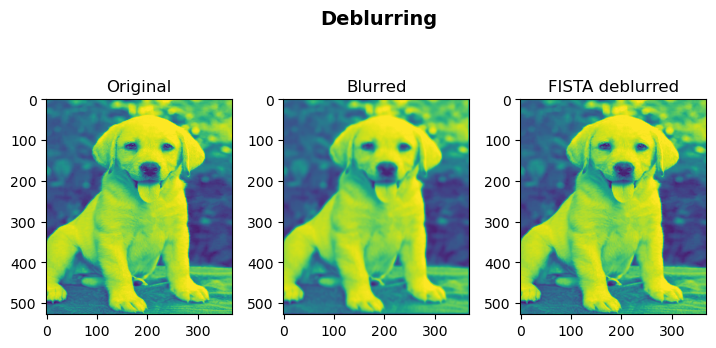

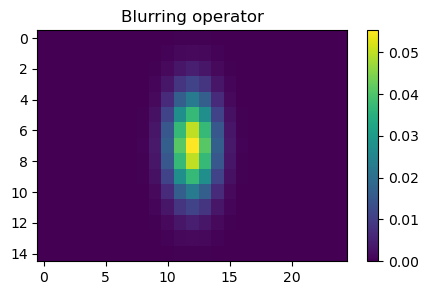

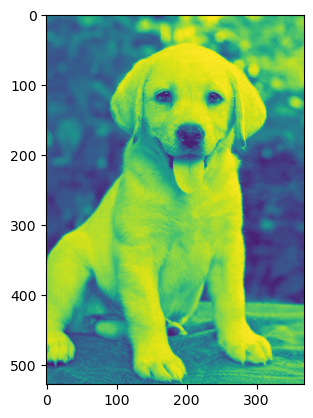

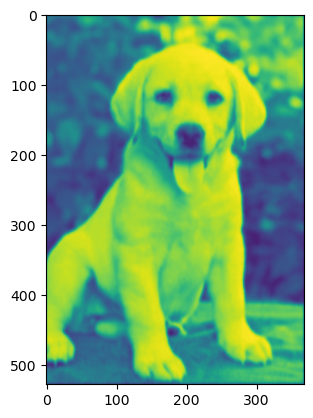

Temps d'exécution pour ISTA: 7.24 secondes
Temps d'exécution pour FISTA: 7.21 secondes
Temps d'exécution total: 224.85 secondes


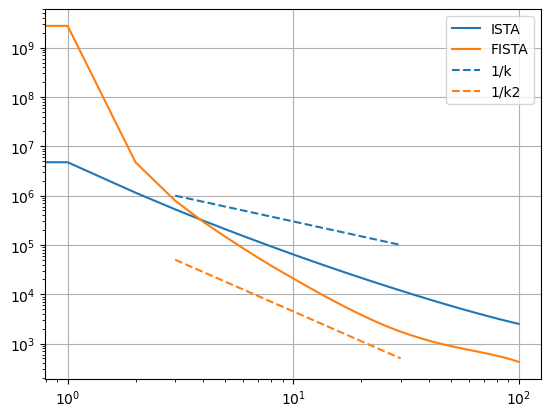

Dimensions du problème: A shape = (194304, 524288)


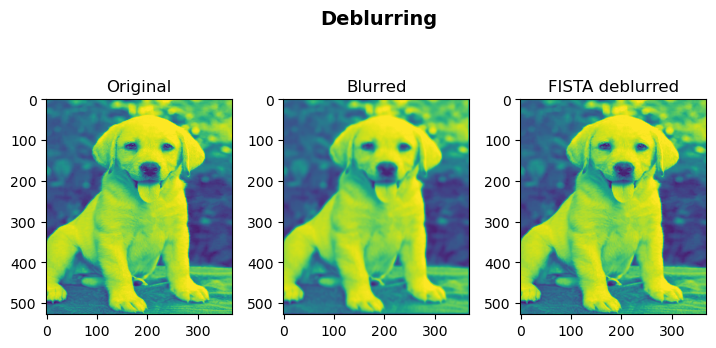

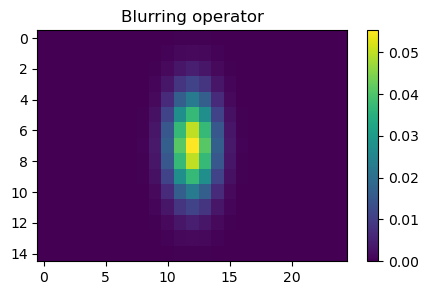

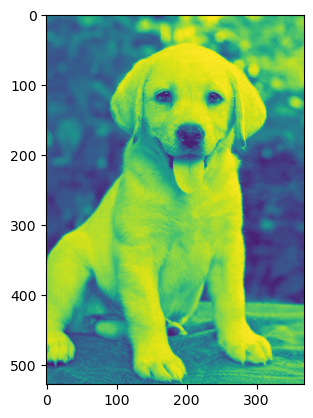

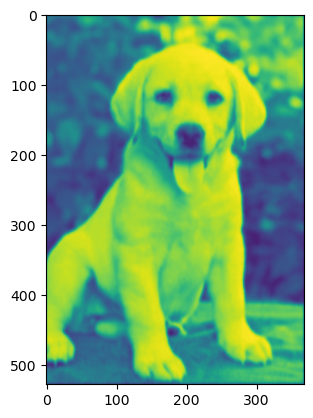

KeyboardInterrupt: 

In [8]:
Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_eps_000001.png")
 
imdeblurfista = run_program(A, b, Wop, eps_value=0.00001, baseline_iter=1000, my_iter=100, filename_courbe="Courbe_eps_000001.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_eps_000001.png")




Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_eps_0001.png")
 
imdeblurfista = run_program(A, b, Wop, eps_value=0.001, baseline_iter=1000, my_iter=100, filename_courbe="Courbe_eps_0001.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_eps_0001.png")



Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_eps_001.png")
 
imdeblurfista = run_program(A, b, Wop, eps_value=0.01, baseline_iter=1000, my_iter=100, filename_courbe="Courbe_eps_001.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_eps_001.png")




Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_eps_1.png")
 
imdeblurfista = run_program(A, b, Wop, eps_value=1, baseline_iter=1000, my_iter=100, filename_courbe="Courbe_eps_1.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_eps_1.png")



## Testing with different values of $\alpha$ 

In [ ]:
Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_alp_1_8.png")
 
imdeblurfista =  run_program(A, b, Wop, filename_courbe="Courbe_alp_1_8.png", alp = (1/8)*1/(2*((A.T @ A).eigs(neigs = 1,symmetric=True))))

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_alp_1_8.png")




Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_alp_1_2.png")
 
imdeblurfista =  run_program(A, b, Wop, filename_courbe="Courbe_alp_1_2.png", alp = (1/2)*1/(2*((A.T @ A).eigs(neigs = 1,symmetric=True))))

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_alp_1_2.png")



Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_alp_3_2.png")
 
imdeblurfista =  run_program(A, b, Wop, filename_courbe="Courbe_alp_3_2.png", alp = (3/2)*1/(2*((A.T @ A).eigs(neigs = 1,symmetric=True))))

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_alp_3_2.png")



Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_alp_3.png")
 
imdeblurfista =  run_program(A, b, Wop, filename_courbe="Courbe_alp_3.png", alp = (3)*1/(2*((A.T @ A).eigs(neigs = 1,symmetric=True))))

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_alp_3.png")



## Experiment with diﬀerent blurring

In [ ]:
Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_blurring_1.png")
 
imdeblurfista = run_program(A, b, Wop, filename_courbe="Courbe_blurring_1.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_blurring_1.png")

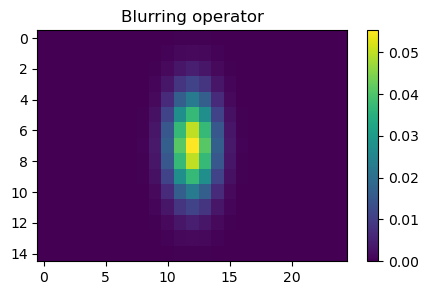

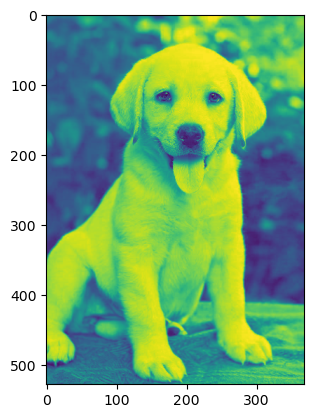

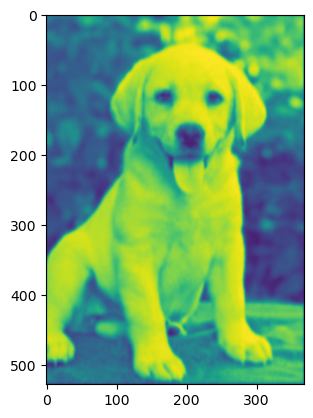

Temps d'exécution pour ISTA: 4.90 secondes
Temps d'exécution pour FISTA: 4.88 secondes
Temps d'exécution total: 146.23 secondes


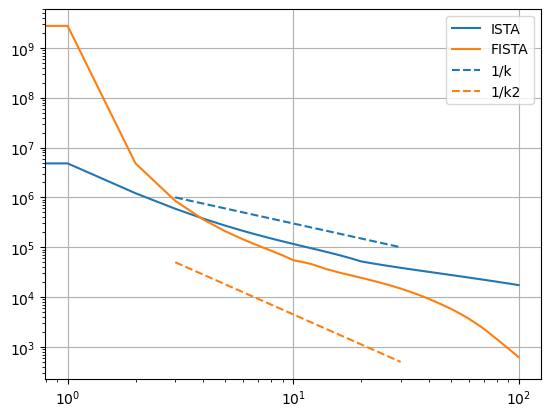

Dimensions du problème: A shape = (194304, 524288)


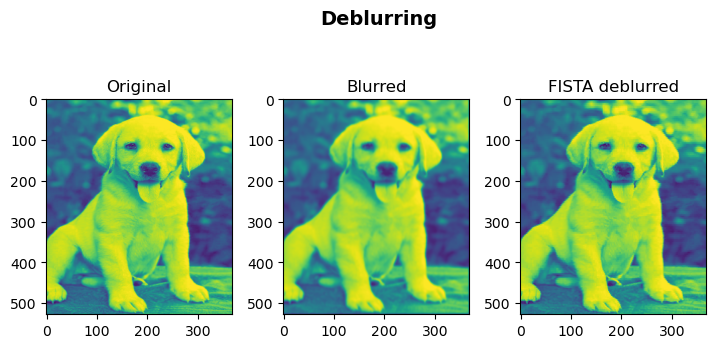

In [10]:
Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_blurring_2.png")
 
imdeblurfista = run_program(A, b, Wop, filename_courbe="Courbe_blurring_2.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_blurring_2.png")

## Diminishing of the sampling size

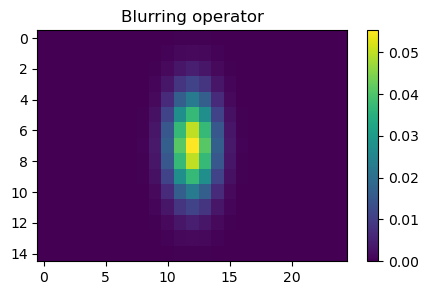

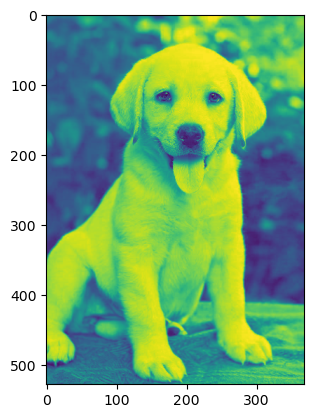

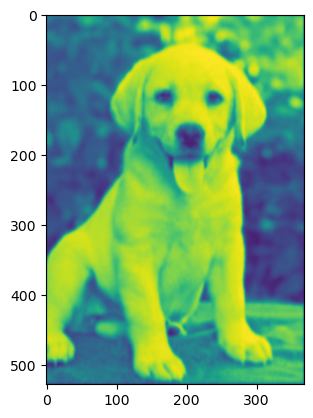

Temps d'exécution pour ISTA: 4.38 secondes
Temps d'exécution pour FISTA: 4.53 secondes
Temps d'exécution total: 139.08 secondes


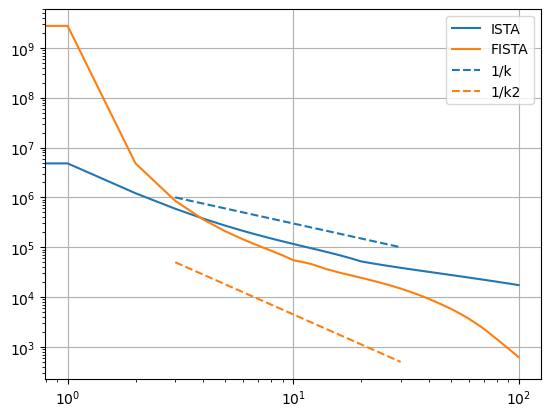

Dimensions du problème: A shape = (194304, 524288)


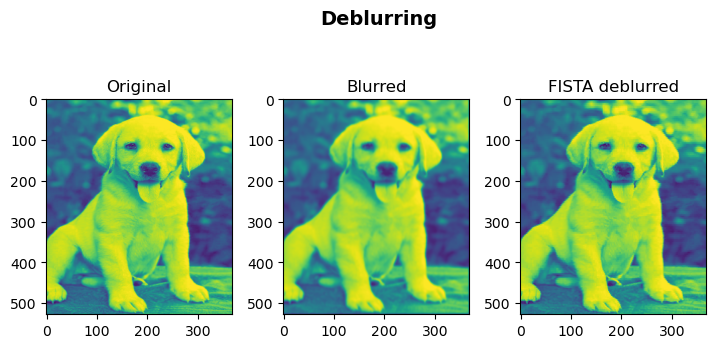

In [12]:
Wop, A, b, im, imblur = load_image_option_I(file_name = "dog_rgb.npy", filename_courbe ="Blurring_operator_sampling_2.png")
 
imdeblurfista = run_program(A, b, Wop, filename_courbe="Courbe_sampling_2.png")

visualise_results(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred_sampling_2.png")

# Going Beyond ISTA: Research questions

In [23]:
from pylops.optimization.basic import lsqr

def my_Douglas_Rachford(A, b, opt_cost, eps=1e-1, niter=100, tol=1e-5):
    
    x = np.ones(A.shape[1]) 
    opt_gap_cost = [0.5 * (np.linalg.norm(A @ x - b, 2))**2 + eps * np.linalg.norm(x, 1)]
    c = A.T @ b
    As = A.T @ A 
    I = pylops.Identity(A.shape[1], dtype="float64")
    AF = As+ I
    for i in range(niter):
 
    
        # Aplicação da atualização com escolha condicional
        conditions = [x  > eps, x  < -eps]
        choices = [x - eps, x + eps]
    
        z = np.select(conditions, choices, default=0)

        w_result =  pylops.optimization.basic.lsqr(AF , 2 * z - x + c, niter=20, atol=1e-4)
        w = w_result[0]  # Extraindo a solução w
        w = np.reshape(w, x.shape)
        
        x = x + w -z
    
        # Cálculo do custo atualizado
        cost = 0.5 * (np.linalg.norm(A @ x - b, 2))**2 + eps * np.linalg.norm(x, 1)
        opt_gap_cost.append(cost-opt_cost)
    
        # Convergência
        if abs(opt_gap_cost[-1] - opt_gap_cost[-2]) < tol:
            break
                
    
    return x, opt_gap_cost

In [25]:
def run_program_Going_Beyond(A, b, Wop, eps_value=0.1, baseline_iter=1000, my_iter=100, filename_courbe="Courbe.png", alp = None):

    start_time_total = time.time()
    
    # Baseline from pylops
    imdeblurfista0, n_eff_iter, cost_history = pylops.optimization.sparsity.fista(
        A, b, eps=eps_value, niter=baseline_iter
    )
    
    if alp is None:
        alp = 1/(2*((A.T @ A).eigs(neigs=1, symmetric=True)))

    opt_cost = cost_history[-1]

    # ISTA
    start_time_ista = time.time()
    my_imdeblurfista, opt_gap_cost = my_fista(
        A, b, opt_cost, eps=eps_value, niter=my_iter, acceleration=False, alp = alp)
    ista_time = time.time() - start_time_ista
    print(f"Temps d'exécution pour ISTA: {ista_time:.2f} secondes")

    # FISTA
    start_time_FISTA = time.time()
    my_imdeblurfista1, opt_gap_cost1 = my_fista(
        A, b, opt_cost, eps=eps_value, niter=my_iter, acceleration=True, alp = alp)
    FISTA_time = time.time() - start_time_FISTA
    print(f"Temps d'exécution pour FISTA: {FISTA_time:.2f} secondes")

    # DOUGLAS RACHFORD
    start_time_DOUGLAS = time.time()
    my_imdeblur_rachford, opt_gap_cost_rachford = my_Douglas_Rachford(
        A, b, opt_cost, eps=eps_value, niter=my_iter)
    DOUGLAS_time = time.time() - start_time_DOUGLAS
    print(f"Temps d'exécution pour Douglas Rachford: {DOUGLAS_time:.2f} secondes")

     # Temps total
    total_time = time.time() - start_time_total
    print(f"Temps d'exécution total: {total_time:.2f} secondes")

    
    plt.loglog(opt_gap_cost, 'C0', label='ISTA')
    plt.loglog(opt_gap_cost1, 'C1', label='FISTA')
    plt.loglog(opt_gap_cost_rachford, 'C2', label='Douglas Rachford')
    plt.grid()
    
    plt.legend()
    plt.savefig(filename_courbe)
    plt.show()
    

    imdeblur_rachford = my_imdeblur_rachford.reshape(A.dims)
    imdeblur_rachford = Wop.H * imdeblur_rachford
    
    # Ajouter des informations sur les dimensions du problème
    print(f"Dimensions du problème: A shape = {A.shape}")

    return imdeblur_rachford


In [26]:
def visualise_results_rashford(im, imblur, imdeblurfista, filename_dog="FISTA_deblurred.png"):
    #Change viridis into gray for castle image.

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle("Deblurring", fontsize=14, fontweight="bold", y=0.95, x=0.32)
    ax1 = plt.subplot2grid((2, 5), (0, 0))
    ax2 = plt.subplot2grid((2, 5), (0, 1))
    ax3 = plt.subplot2grid((2, 5), (0, 2))

    ax1.imshow(im, cmap="viridis", vmin=0, vmax=250)
    ax1.axis("tight")
    ax1.set_title("Original")
    ax2.imshow(imblur, cmap="viridis", vmin=0, vmax=250)
    ax2.axis("tight")
    ax2.set_title("Blurred")

    ax3.imshow(imdeblurfista, cmap="viridis", vmin=0, vmax=250)
    ax3.axis("tight")
    ax3.set_title("DOUGLAS - RashFord deblurred")

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

    plt.savefig(filename_dog, bbox_inches='tight')
    plt.show()

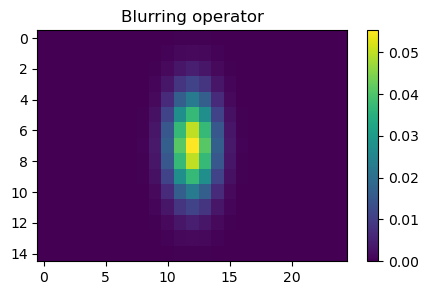

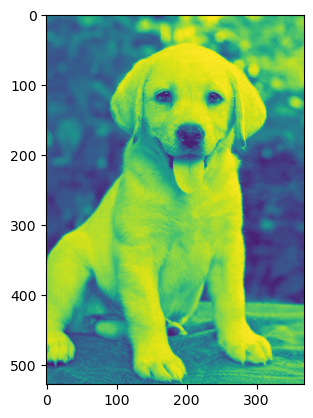

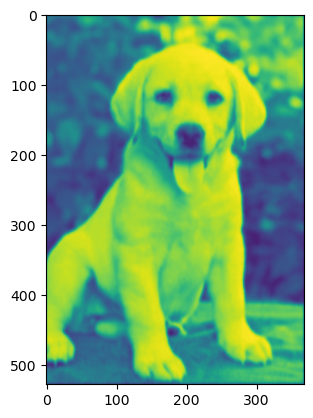

Temps d'exécution pour ISTA: 7.29 secondes
Temps d'exécution pour FISTA: 9.23 secondes
Temps d'exécution pour Douglas Rachford: 94.55 secondes
Temps d'exécution total: 389.54 secondes


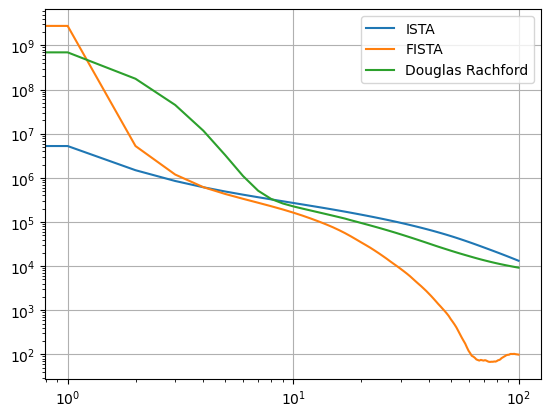

Dimensions du problème: A shape = (194304, 524288)


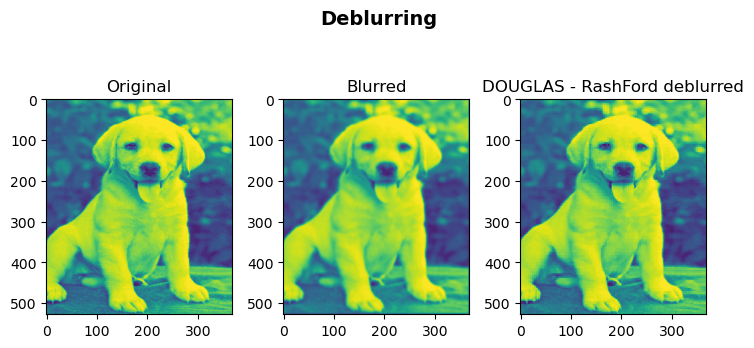

In [29]:
Wop, A, b, im, imblur = load_image_option_I()
 
imdeblur_rachford = run_program_Going_Beyond(A,b, Wop,eps_value=1, baseline_iter=1000, my_iter=100, filename_courbe="Courbe_ALL_MODELS.png")

visualise_results_rashford(im, imblur, imdeblur_rachford,filename_dog="DOUGLAS_RASHFORD_deblurred.png")